# small dataset XRD classification using machine learning

## Introduction
This is meant to be a (relatively) self-contained example of XRD classifcation on small dataset via physics based data agumentation
The overall procedure is:
   1. Load the experimental and theorectical XRD spectra with dimenionality labels
   2. Data preprocessing for experimental data
   3. Data augmentation for both experimental and theorectical spectra based on the characteristics of thin film XRD measurement
   4. Perform dimensionlity/space group classification based on the post-processed data
   5. Cross validation and hyperparameter tuning

## Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [165]:
import time  
from sklearn.metrics import accuracy_score
import numpy as np  
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Import multiple classifcation algorithms from scikt-learn

In [166]:
# Multinomial Naive Bayes Classifier
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha=0.01)
    model.fit(train_x, train_y)
    return model


# KNN Classifier
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(train_x, train_y)
    return model


# Logistic Regression Classifier
def logistic_regression_classifier(train_x, train_y):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(penalty='l2')
    model.fit(train_x, train_y)
    return model


# Random Forest Classifier
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# Decision Tree Classifier
def decision_tree_classifier(train_x, train_y):
    from sklearn import tree
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)
    return model


# GBDT(Gradient Boosting Decision Tree) Classifier
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# SVM Classifier
def svm_classifier(train_x, train_y):
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    model.fit(train_x, train_y)
    return model



 # 3 layer neural network classficiation
def mlp_classifier(train_x,train_y):
    from sklearn.neural_network import MLPClassifier
    model =  MLPClassifier(hidden_layer_sizes=(256,256,256), max_iter=200, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-6, random_state=1,
                    learning_rate_init=.1)
    model.fit(train_x,train_y)
    return model

Let's create functions that can read .ASC and .xy files from subfolders

In [167]:
#Gets .ASC files from directory
def spectra_list(path,excluded):
    file_pth= [os.path.join(d, x) for d, dirs, files in os.walk(path) for x in files if x.endswith(".ASC") and excluded not in x]
    return file_pth
#Gets .XY files from directory
def spectra_list2(path):
    file_pth= [os.path.join(d, x) for d, dirs, files in os.walk(path) for x in files if x.endswith(".xy")]
    return file_pth
#Groups all curves within a symmetry group into as single dataframe
def group(spectra,k):
    groups=[]
    for indx,vals in enumerate(spectra[k]):
        groups.append(pd.read_csv(spectra[k][indx], delim_whitespace=True, header=None))
        df=pd.concat(groups, axis=1)
    return df

Since the XRD intensities are arbitatry units, we will scale the XRD intensities from 0 to 1 for ML input. Let's define functions that normalize the data from 0 to 1 based on the data structure. You can use min_max scaler from SK learn but since the data strucuture is not starndardized. We fine our own min_max scaler

In [168]:
#data normalization from 0 to 1 for double column dataframe
def normdata(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1//2])
    for i in range(w1//2):
        ndata[:,i]=(data[:,2*i+1]-min(data[:,2*i+1]))/(max(data[:,2*i+1])-min(data[:,2*i+1]))
    return ndata
#data normalization from 0 to 1 for single column dataframe
def normdatasingle(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1])
    for i in range(w1):
        ndata[:,i]=(data[:,i]-min(data[:,i]))/(max(data[:,i])-min(data[:,i]))
    return ndata

We only have <200 specta in our subfolders, let's define data augmention functions based on our domain knowledge on thin-film and power XRD spectrum

In [169]:
#data augmendatation for simulated XRD spectrum
def augdata(data,num,dframe,minn,maxn,labels):
    np.random.seed(1234)
    (len1,w1) = np.shape(data)
    augd =np.zeros([len1,num])
    naugd=np.zeros([len1,num])
    newaugd=np.zeros([len1,num])
    crop_augd = np.zeros([maxn-minn,num])
    par1 = labels
    pard = []
    for i in range(num):
        rnd = np.random.randint(0,w1)
        # create the first filter for peak elimination
        dumb= np.repeat(np.random.choice([0,1,1],300),len1//300)
        dumb1= np.append(dumb,np.zeros([len1-len(dumb),]))
        # create the second filter for peak scaling
        dumbrnd= np.repeat(np.random.rand(100,),len1//100)
        dumbrnd1=np.append(dumbrnd,np.zeros([len1-len(dumbrnd),]))
        #peak eleminsation and scaling
        augd[:,i] = np.multiply((data[:,rnd]),dumbrnd1)
        augd[:,i] = np.multiply(augd[:,i],dumb1)
        #nomrlization
        naugd[:,i] = (augd[:,i]-min(augd[:,i]))/(max(augd[:,i])-min(augd[:,i])+1e-9)
        pard.append (par1[2*rnd])
        #adding shift
        cut = np.random.randint(-20*1,20)
        #XRD spectrum shift to left
        if cut>=0:
            newaugd[:,i] = np.append(naugd[cut:,i],np.zeros([cut,]))
        #XRD spectrum shift to right
        else:
            newaugd[:,i] = np.append(naugd[0:len1+cut,i],np.zeros([cut*-1,]))

        crop_augd[:,i] = newaugd[minn:maxn,i]
#
    return newaugd, pard,crop_augd
#data augmendatation for experimental XRD spectrum
def exp_augdata(data,num,label):
    np.random.seed(1234)
    (len1,w1) = np.shape(data)
    augd =np.zeros([len1,num])
    naugd=np.zeros([len1,num])
    newaugd=np.zeros([len1,num])
    par=np.zeros([num,])
    for i in range(num):
        rnd = np.random.randint(0,w1)

        # create the first filter for peak elimination
        dumb= np.repeat(np.random.choice([0,1,1],300),len1//300)
        dumb1= np.append(dumb,np.zeros([len1-len(dumb),]))
        # create the second filter for peak scaling
        dumbrnd= np.repeat(np.random.rand(200,),len1//200)
        dumbrnd1=np.append(dumbrnd,np.zeros([len1-len(dumbrnd),]))
        #peak eleminsation and scaling
        augd[:,i] = np.multiply((data[:,rnd]),dumbrnd1)
        augd[:,i] = np.multiply(augd[:,i],dumb1)
        #nomrlization
        naugd[:,i] = (augd[:,i]-min(augd[:,i]))/(max(augd[:,i])-min(augd[:,i])+1e-9)
        par[i,] =label[rnd,]
        #adding shift
        cut = np.random.randint(-20*1,20)
        #XRD spectrum shift to left
        if cut>=0:
            newaugd[:,i] = np.append(naugd[cut:,i],np.zeros([cut,]))
        #XRD spectrum shift to right
        else:
            newaugd[:,i] = np.append(naugd[0:len1+cut,i],np.zeros([cut*-1,]))

    return newaugd, par

The experimental data contains noise and background. Let's write a function to remove it.

In [170]:
#extracting exprimental data
def exp_data_processing (data,minn,maxn,window):
    (len1,w1) = np.shape(data)
    nexp1 =np.zeros([maxn-minn,w1])
    for i in range(w1):
        #savgol_filter to smooth the data
         new1 = savgol_filter(data[minn:maxn,i], 31, 3)
         #peak finding
         zf= find_peaks_cwt(new1, np.arange(10,15), noise_perc=0.01)
         #background substraction
         for j in range(len(zf)-1):
             zf_start= np.maximum(0,zf[j+1]-window//2)
             zf_end = np.minimum(zf[j+1]+window//2,maxn)
             peak = new1[zf_start:zf_end]

             ##abritaryly remove 1/4 data
             npeak = np.maximum(0,peak-max(np.partition(peak,window//5 )[0:window//5]))
             nexp1[zf_start:zf_end,i]= npeak
    return nexp1

## 1. Load the data
The XRD spectrums contain both experimental and theorectal data. The theorectal spectra are power XRD spectra which comes from ICSD database. ICSD prohibits distributing their data . Hence, modifed data is used for this demo. The compound formular of each XRD spectra is also not given due to potential confilcts of interests.


In [171]:
# Load simulated XRD spectra

theor=pd.read_csv('theor.csv',header=None)

# Load meaured XRD spectra

exp=pd.read_csv('exp.csv',header=None)

We can take a look at the data

In [172]:
theor.head(10)

,0,1,2,3,4,5,6,7,8,9,...,318,319,320,321,322,323,324,325,326,327
0,0D,0D,0D,0D,0D,0D,0D,0D,0D,0D,...,3D,3D,3D,3D,3D,3D,3D,3D,3D,3D
1,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500,...,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500,5.039999962,1500
2,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500,...,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500,5.079999961,1500
3,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500,...,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500,5.11999996,1500
4,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500,...,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500,5.159999959,1500
5,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500,...,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500,5.199999958,1500
6,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500,...,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500,5.239999957,1500
7,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500,...,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500,5.279999956,1500
8,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500,...,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500,5.319999956,1500
9,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500,...,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500,5.359999955,1500


Let's convert this big matrix from string to number and take out the first row as "labels" for our machine learning problem

In [173]:
#label
theor_labels= theor.iloc[0]
#take out the first row
theor = theor.drop(theor.index[0])
#convert from string to number
theor = theor.apply(pd.to_numeric, errors='coerce')
#convert from pandas dataframe to numpy array
theor_arr=theor.as_matrix()
#normalization
ntheor = normdata (theor_arr)

Let's plot the theorectical spectra

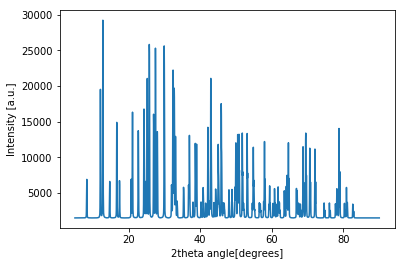

In [174]:
plt.plot(theor_arr[:,0],theor_arr[:,1],label='Theorectical')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Intensity [a.u.]')
plt.show()

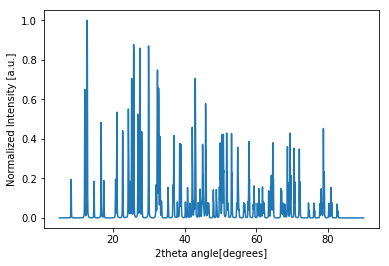

In [175]:
plt.plot(theor_arr[:,0],ntheor[:,0],label='Theorectical')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Normalized Intensity [a.u.]')
plt.show()

What is size of our theorectical XRD spectra

In [176]:
ntheor.shape

(2125, 164)

Let's have a look at the experimental spectra

In [177]:
exp.head(10)

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
0,0D,0D,0D,0D,0D,0D,0D,0D,0D,0D,...,3D,3D,3D,3D,3D,3D,3D,3D,3D,3D
1,5,1457,5,1657,5,1539,5,1374,5,1445,...,5,591,5,1041,5,641,5,5378,5,1412
2,5.04,1420,5.04,1654,5.04,1352,5.04,1348,5.04,1464,...,5.04,575,5.04,1058,5.04,627,5.04,5314,5.04,1408
3,5.08,1379,5.08,1650,5.08,1377,5.08,1358,5.08,1348,...,5.08,575,5.08,1038,5.08,591,5.08,5356,5.08,1451
4,5.12,1336,5.12,1594,5.12,1346,5.12,1403,5.12,1405,...,5.12,627,5.12,1047,5.12,599,5.12,5153,5.12,1418
5,5.16,1305,5.16,1583,5.16,1375,5.16,1332,5.16,1336,...,5.16,586,5.16,1001,5.16,563,5.16,5196,5.16,1375
6,5.2,1384,5.2,1598,5.2,1353,5.2,1355,5.2,1347,...,5.2,619,5.2,993,5.2,591,5.2,5402,5.2,1361
7,5.24,1364,5.24,1573,5.24,1352,5.24,1341,5.24,1352,...,5.24,602,5.24,980,5.24,598,5.24,5056,5.24,1301
8,5.28,1347,5.28,1572,5.28,1285,5.28,1298,5.28,1344,...,5.28,552,5.28,925,5.28,603,5.28,5118,5.28,1317
9,5.32,1398,5.32,1528,5.32,1299,5.32,1329,5.32,1384,...,5.32,573,5.32,945,5.32,597,5.32,5149,5.32,1349


We will do the same operation as what we have done for the theorectical data

In [178]:
#labels
exp_labels= exp.iloc[0]
#take out the first row
exp = exp.drop(exp.index[0])
#string to number
exp=exp.apply(pd.to_numeric, errors='coerce')
#dataframe to array
exp_arr=exp.as_matrix()

#We didn't simulate the peak at 5.00 degrees, so start from 5.04
exp_arr=exp_arr[1:,:]

#normalization
ntheor = normdata (theor_arr)
nexp = normdata (exp_arr)

What is the shape of this matrix after normlization? (in othere words, what are the available experimental data size)

In [179]:
nexp.shape

(3248, 73)

## 2. Data preprocessing
### Trim the data
Since not all the data has the same range(2theta angles), we need to unify the range 

In [180]:
#define the range for spectrum (this is to unify the measurement range)
exp_min = 0
exp_max = 1350
theor_min = 0


We can plot  the measured spectra

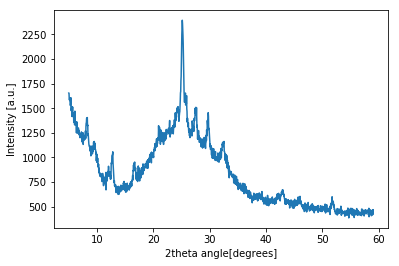

In [181]:
plt.plot(exp_arr[exp_min:exp_max,0],exp_arr[exp_min:exp_max,3],label='Experimental data')
plt.xlabel('2theta angle[degrees]')
plt.ylabel('Intensity [a.u.]')
plt.show()

### Background and noise subtraction
window size is a hyperparamtere that we can change to determine the width of peaks. We call a function which is previouly defined(exp_data_processing) to remove the measurement noise and singals from the substrate

In [182]:
#window size for experimental data extraction
window =15
theor_max = theor_min+exp_max-exp_min
#experimetal data input
post_exp= normdatasingle(exp_data_processing (nexp,exp_min,exp_max,window))

Let's plot the experimetal spectra again after data post-processing

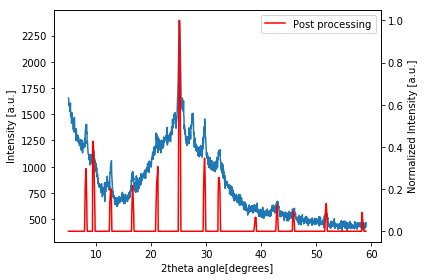

In [183]:
fig ,ax1 = plt.subplots()
ax1.plot(exp_arr[exp_min:exp_max,0],exp_arr[exp_min:exp_max,3])
ax1.set_xlabel('2theta angle[degrees]')
ax1.set_ylabel('Intensity [a.u.]')
ax2 = ax1.twinx()
ax2.plot(exp_arr[exp_min:exp_max,0],post_exp[:,1],color ='r')
ax2.set_ylabel('Normalized Intensity [a.u.]')
fig.tight_layout()
plt.legend(['Post processing'])
plt.show()

## 3. Data agumentation 

Let's augment the data for the theorectical dataset first

Specify how many data points we augmented for theorectical and experimental data

In [204]:
#let's start to do the data augmentation.
theor_aug_num = 1000
exp_aug_num = 1000
augd,pard,crop_augd = augdata(ntheor,theor_aug_num,theor,theor_min,theor_max,theor_labels)



Plot augmented data

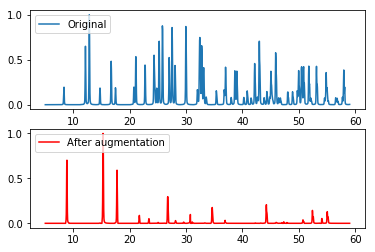

In [205]:
rnd = 0#np.random.randint(0,100)
plt.subplot(2, 1, 1)
plt.plot(theor_arr[theor_min:theor_max,0],ntheor[theor_min:theor_max,(rnd)],label='Original')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(theor_arr[theor_min:theor_max,0],crop_augd[:,(rnd)],label='After augmentation',color='r')

plt.legend(loc='upper left')
plt.show()

Now we augmented the spectra both for experiment and theory from ~200 to 2000!

We should add labels to those augmented spectra 

In [206]:
#convert theorectical label from dimensionality to numbers
directory = ['0','2','3']
label_t=np.zeros([len(pard),])
for i in range(len(pard)): 
    temp = pard[i]
    label_t[i]=directory.index(temp[0])

#convert experimental label from dimensionality to numbers

par_exp = exp_labels

label_exp=np.zeros([len(par_exp)//2,])

for i in range(len(par_exp)//2):

    temp = par_exp[2*i]
    label_exp[i]=directory.index(temp[0])

## 4 Classification and cross validation using various ML algorithms

After data extraction, data preprocessing and data augmentation. We have ~2000 spectra now as an Input to train our machine learning algorithm. We can use part of those spectra to fine tune these hyperparameters and test the "untouched" spectra . The test  was done in the paper and will not be conducted here for the sake of time
Let's determine how many spectra we want to use to do a cross validation for our machine learning algorithm.

In [207]:
#define the number of experimetal spectra we use for a N flold cross validation
exp_num =60  
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]
#train and test split for the experimental data
#X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp
      #  ,y_exp , test_size=0.33,random_state=1)



#train and test split for the theorectical data
X_th = np.transpose(crop_augd )
y_th = label_t
#X_train_th, X_test_th, y_train_th, y_test_th = train_test_split( 
       # X_th, y_th, test_size=0.33,random_state=1)


Split the data to N folds ---(N-1)/N% training, 1/N% test) 

In [208]:
n_fold = 5
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=30)

choose your favorate machine learning algorithem

In [209]:
test_classifier = ['RF']
classifiers = {'NB':naive_bayes_classifier,   
                   'KNN' :knn_classifier, 
                   'LR':logistic_regression_classifier,  
                   'RF':random_forest_classifier,  
                   'DT':decision_tree_classifier,  
                   'SVM':svm_classifier,                    
                   'GBDT':gradient_boosting_classifier,
                   'NN':mlp_classifier
    }  

In [210]:
accuracy_exp = np.empty((n_fold,1)) 
start_time = time.time()   
for classifier in test_classifier: 
    print ('******************* %s ********************' % test_classifier)
    for k, (train, test) in enumerate(k_fold.split(X_exp, y_exp)):       
           
            #data augmentation to experimenal traning dataset
            temp_x = X_exp[train]
            temp_y = y_exp[train]
            exp_train_x,exp_train_y = exp_augdata(temp_x.T,exp_aug_num ,temp_y)
            #combine theorectical and experimenal dataset for training
            train_combine = np.concatenate((X_th,exp_train_x.T))
            train_y = np.concatenate((y_th,exp_train_y))
             
            model = classifiers[classifier](train_combine, train_y)  
    
            #predict experimental prediction accuracy
            predict_exp = model.predict(X_exp[test])        
            accuracy_exp[k] = accuracy_score(y_exp[test], predict_exp)  
            print ('accuracy_exp: %.2f%%' % (100 * accuracy_exp[k]))
            # 5 fold cross validation

******************* ['RF'] ********************
accuracy_exp: 75.00%
accuracy_exp: 41.67%
accuracy_exp: 58.33%
accuracy_exp: 66.67%
accuracy_exp: 58.33%


In [211]:
print ('CV  took %fs!' % (time.time() - start_time) )
print('Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_exp), np.mean(np.abs(accuracy_exp))))

CV  took 6.113331s!
Cross-validation results:
Folds: 5, mean acc: 0.600


We can fine tune the hyperparameters in both the classifers and data preproessing&augmentation for each method we tried. We find a three layer DNN performs better than other classifiers for both cross validation and newly synthezied validation dataset.